<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Compiling-data-into-dataframe" data-toc-modified-id="Compiling-data-into-dataframe-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Compiling data into dataframe</a></span></li><li><span><a href="#Generating-extra-data" data-toc-modified-id="Generating-extra-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Generating extra data</a></span></li><li><span><a href="#Checking-predictions" data-toc-modified-id="Checking-predictions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Checking predictions</a></span></li></ul></div>

In [118]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("/Users/paytonrodman/projects/plant_classification")

from pathlib import Path

PROJ_ROOT = Path(os.getcwd())
DATA_DIR = PROJ_ROOT / "data"
PROCESSED_DATA_DIR = DATA_DIR / "processed"

TRAIN_DATA_DIR = PROCESSED_DATA_DIR / "train"
TEST_DATA_DIR = PROCESSED_DATA_DIR / "test"
VALID_DATA_DIR = PROCESSED_DATA_DIR / "valid"
PREDICT_DATA_DIR = PROCESSED_DATA_DIR / "predict"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Classification using tensorflow
## Compiling data into dataframe

We're going to use `tensorflow` with `keras` to do our classification. With this package, we can use a particular module called `flow_from_dataframe()` which allows us to read data from a list of file paths, but to do so we need to supply it with a dataframe with all relevant information.

In [119]:
import glob
import pandas as pd

def build_dataframe(directory):
    data_dict = {'file_path': [], 'label': []}
    
    for folder in list(glob.glob(str(directory)+'/*')):
        if folder.startswith('.'): # ignore hidden files
            continue
        disease_label = folder.split()[-2]
    
        for file in list(glob.glob(str(folder)+'/*')):
            data_dict['file_path'].append(file)
            data_dict['label'].append(disease_label)
    
    data_df = pd.DataFrame(data_dict)
    return(data_df)

train_df = build_dataframe(TRAIN_DATA_DIR)
test_df = build_dataframe(TEST_DATA_DIR)
valid_df = build_dataframe(VALID_DATA_DIR)

valid_df

,file_path,label
0,/Users/paytonrodman/projects/plant_classificat...,diseased
1,/Users/paytonrodman/projects/plant_classificat...,diseased
2,/Users/paytonrodman/projects/plant_classificat...,diseased
3,/Users/paytonrodman/projects/plant_classificat...,diseased
4,/Users/paytonrodman/projects/plant_classificat...,diseased
...,...,...
105,/Users/paytonrodman/projects/plant_classificat...,diseased
106,/Users/paytonrodman/projects/plant_classificat...,diseased
107,/Users/paytonrodman/projects/plant_classificat...,diseased
108,/Users/paytonrodman/projects/plant_classificat...,diseased


## Generating extra data

Another very useful tool in the `tensorflow`/`keras` toolbox is the `ImageDataGenerator` module. This augments our existing training data sets by rotating, zooming, and flipping our images, and the specific options we turn on here depends on the kind of image we're studying and whether it has any inherent directionality to it. Our dataset is a bunch of isolated leaves, so there's no real directionality: leaves can be realistically photographed in any orientation. Augmented data is never as good as real data—it likely won't improve the model fit—but it can delay overfitting. On the other hand, the more augmented data we add, the harder we make it for the model to generalise, which may be unhelpful when we have such limited data to train on to begin with.

We can also perform the necessary rescaling at this point (image colour data has a range of 0-255), which we'll apply to the testing and validation data sets too.

In [120]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# expand our training dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# rescale the test and validation data colour values
test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

In [141]:
image_shape = (256, 256, 3) # size of images
num_classes = 2 # disease status
batch_size = 10 # must be divisor of no. test images (110)

print("Training images:")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col='file_path',
    y_col='label',
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

print("Testing images:")
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col='file_path',
    y_col='label',
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print("Validation images:")
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=None,
    x_col='file_path',
    y_col='label',
    target_size=image_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Training images:
Found 4274 validated image filenames belonging to 2 classes.
Testing images:
Found 110 validated image filenames belonging to 2 classes.
Validation images:
Found 110 validated image filenames belonging to 2 classes.


# Fitting a model

With our data compiled, augmented, and generated, we can now work on the CNN model. There are innumerable ways a model can be constructed, and the potential complexity is unlimited. I, however, want to run this model on my own personal laptop (at the time of writing, a 2019 model MacBook Pro with Intel Core i9). We also don't have that much data to begin with, and to reduce compute time I've rescaled and cropped our images to 256x256 which will further limit the model's ability; as a result, a too-complex model can quickly overfit the data.

With those constraints in mind, our model is going to contain 3 main components:

1. A series of convolution layers with increasing filter size, each passed through a rectifier function (ReLu) for feature detection, and each followed by Max Pooling, Batch Normalisation, and Dropout.

2. A fully-connected layer, also followed by Batch Normalisation and Dropout.

3. Our final classifier layer with `softmax` activation.

In [139]:
import keras
from keras.models import Sequential
from keras import layers
from keras import activations

print("[INFO] compiling model...")

keras.backend.clear_session()

model = Sequential()
model.add(keras.Input(shape=image_shape))

# add convolution at increasing filter size
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

# add fully-connected layer
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(128, activation='sigmoid'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.2))

# softmax classifier
model.add(layers.Dense(2, activation='softmax'))

# initiate optimizer
opt = keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

[INFO] compiling model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,962 (441.26 KB)

 Trainable params: 112,258 (438.51 KB)

 Non-trainable params: 704 (2.75 KB)

In [140]:
import scipy as sc

epochs = 20

print(f"[INFO] training network for {epochs} epochs...")
H = model.fit(train_generator,
              epochs=epochs,
              validation_data=valid_generator)

[INFO] training network for 20 epochs...


/opt/anaconda3/envs/plant_classification/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 263s 609ms/step - accuracy: 0.5170 - loss: 1.1838 - val_accuracy: 0.5455 - val_loss: 0.7108
Epoch 2/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 250s 584ms/step - accuracy: 0.5520 - loss: 0.8222 - val_accuracy: 0.5545 - val_loss: 0.6848
Epoch 3/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 270s 630ms/step - accuracy: 0.5842 - loss: 0.7305 - val_accuracy: 0.5818 - val_loss: 0.6675
Epoch 4/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 280s 655ms/step - accuracy: 0.6174 - loss: 0.6943 - val_accuracy: 0.6000 - val_loss: 0.6586
Epoch 5/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 279s 650ms/step - accuracy: 0.6085 - loss: 0.7057 - val_accuracy: 0.6000 - val_loss: 0.6586
Epoch 6/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 278s 650ms/step - accuracy: 0.6351 - loss: 0.6715 - val_accuracy: 0.6182 - val_loss: 0.6459
Epoch 7/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 278s 650ms/step - accuracy: 0.6432 - loss: 0.6540 - val_accuracy: 0.6273 - val_loss: 0.6519
Epoch 8/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 277s 647ms/step - accuracy: 0.6221 -

# Evaluating the model

With the model trained, we can now evaluate it. But first, we should check that the model has converged the way it should by looking at the trend in accuracy and loss over time. Particular patterns in these variables can hint at model issues or overfitting.

In [126]:
import numpy as np
import matplotlib.pyplot as plt 

def plot_model_outcomes(model, epochs):
    plt.style.use("ggplot")
    plt.figure(figsize=(15, 5))

    plt.subplot(121)
    plt.plot(np.arange(0, epochs), model.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), model.history["val_accuracy"], label="val_acc")
    plt.title("Accuracy", size=15)
    plt.xlabel("Epoch no.")
    plt.legend()
    
    plt.subplot(122)
    plt.plot(np.arange(0, epochs), model.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), model.history["val_loss"], label="val_loss")
    plt.title("Loss", size=15)
    plt.xlabel("Epoch no.")
    plt.legend()

    plt.show()

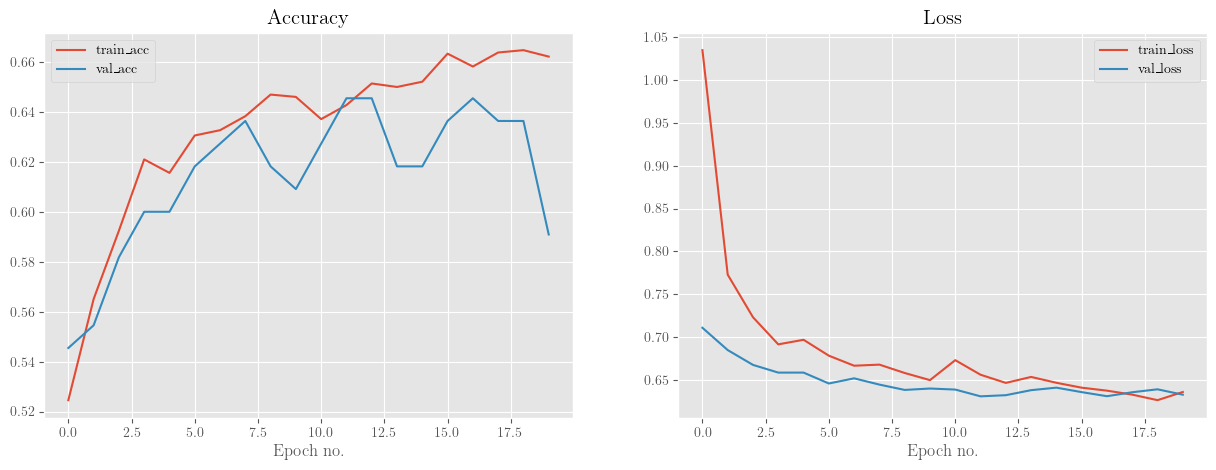

In [142]:
plot_model_outcomes(H, epochs)

Our results are not super great but not unexpected! Our accuracy measurements are not perfectly smooth due to the augmentation we added. We can see that the validation accuracy is slightly below that of the training, suggesting some mild overfitting.

The actual values in our case (~60-70% for accuracy and loss) aren't that great. It's possible that this could be improved by running more epochs, but given the small dataset, we would likely hit overfitting before too long. The best solution in this case would be to add more data, more than anything. Training a CNN is expensive, and we have neither the data nor the computing resources to make a state-of-the-art model.

## Checking predictions

In a classification model like this one, sometimes art (computing) imitates life a little too closely and the model can become lazy: guessing just one of the classifications over and over. This is more likely to happen if there is an imbalance in the testing or training data sets, and the model will simply default to the most prevalent class. Our data is already very well-balanced, so that's unlikely to be an issue, but it's useful to check anyway.

[INFO] evaluating network...
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
              precision    recall  f1-score   support

    diseased       0.57      0.78      0.66        55
     healthy       0.66      0.42      0.51        55

    accuracy                           0.60       110
   macro avg       0.62      0.60      0.59       110
weighted avg       0.62      0.60      0.59       110

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.6041 - loss: 0.6350
Test loss: 0.6327858567237854
Test accuracy: 0.5909090638160706


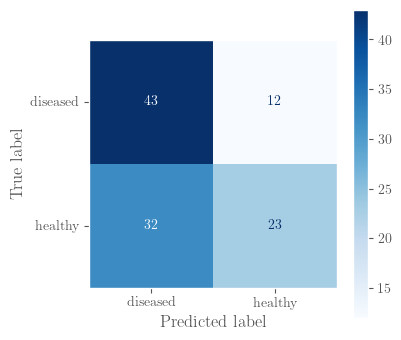

In [165]:
import sklearn.metrics as metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import math

print("[INFO] evaluating network...")

def get_model_evaluation(model_name, test_gen, valid_gen, batch_size):
    test_steps_per_epoch = math.ceil(test_gen.samples / test_gen.batch_size)
    
    predictions = model_name.predict(test_gen, steps=test_steps_per_epoch)
    
    # Get most likely class
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_gen.classes
    class_labels = list(test_gen.class_indices.keys())
    report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(report)
    
    score = model_name.evaluate(valid_gen, batch_size=batch_size)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    cm = confusion_matrix(true_classes, predicted_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.grid(False)
    plt.show()

get_model_evaluation(model, test_generator, valid_generator, batch_size)

From the decision matrix above, we can see that the model is usually okay at predicting diseased leaves, but struggles much more in determining healthy leaves. To me, this suggests that the model is underpowered and has not managed to identify or learn those features which indicate disease, and so struggles with any case that is ambiguous. And that's honestly a pretty reasonable outcome given how few images we have (4274 training and 110 testing), and how varied they are (covering 12 plant species).

We have a few images that we can try to predict, so let's look at those:

8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


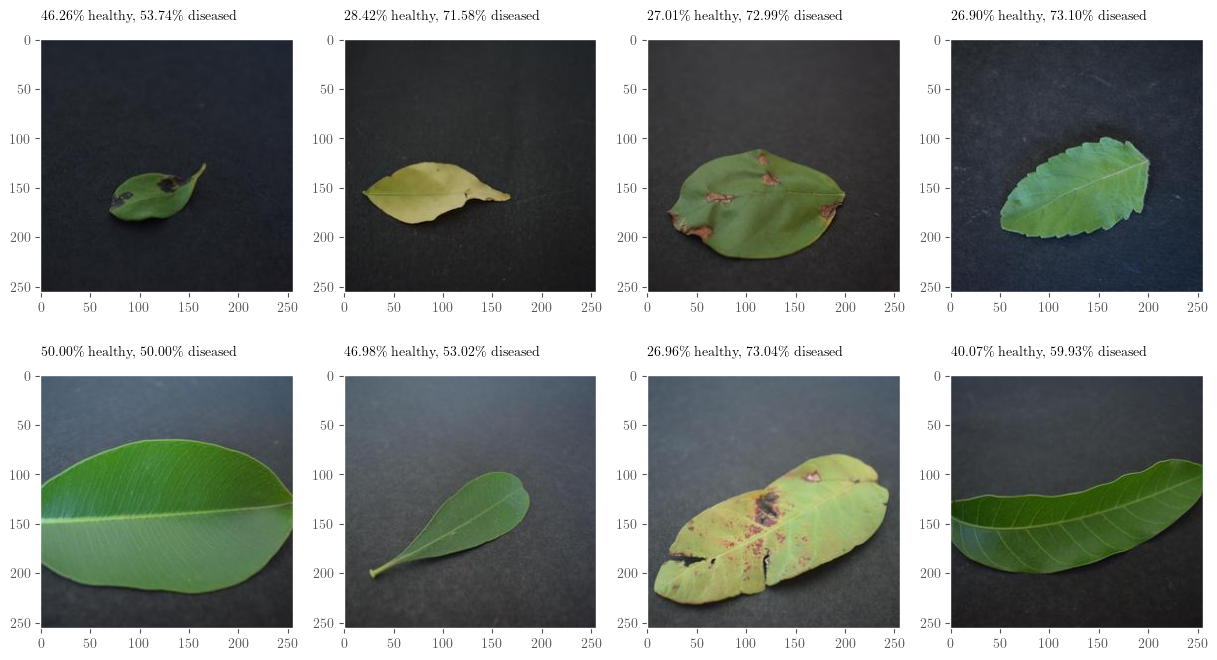

In [170]:
import matplotlib.pyplot as plt 

def plot_predict(model_name, image_path, ax):
    img = keras.utils.load_img(str(image_path), target_size=(256,256))
    ax.imshow(img)
    ax.grid(False)

    img_array = keras.utils.img_to_array(img)
    img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

    predictions = model_name.predict(img_array)
    score = float(keras.ops.sigmoid(predictions[0][0]))
    ax.annotate(f"{100 * (1 - score):.2f}\% healthy, {100 * score:.2f}\% diseased", (0,0), (0, -20))

files_to_predict = list(glob.glob(str(PROCESSED_DATA_DIR / 'predict')+'/*'))

# create a figure with 2 x 4 subplots
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
ax_list = list(axes.flat)[::-1]
num_subplots = len(ax_list)
print(num_subplots)
for i in range(num_subplots):
    ax = ax_list.pop()
    plot_predict(model, files_to_predict[i], ax)


In conclusion, our model is... not too great. It's reasonably confident for the more obviously diseased leaves, but for clearly healthy ones it either errs slightly on the side of 'diseased', or is otherwise completely unsure. 

# Comparison to other models

The biggest issue with our model is that we simply don't have the data or the computing resources to properly train it. One solution to this problem is to take a pre-trained model and either use it straight from the box or make a few adjustments to customise it to our data. This is called **transfer learning**, and it's very useful in cases like ours.

We're going to use a pre-trained model called [MobileNetV2](https://arxiv.org/abs/1801.04381). It's optimised to run with very little computational resources ('Mobile', as in 'mobile phone') and has been trained on the [ImageNet](https://www.image-net.org/) database of more than a million images separated in 1000 categories.  

In [178]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(input_shape=image_shape, include_top=False, weights='imagenet')
for layer in base_model.layers[:-4]:
    layer.trainable = False
   
MobileNetV2_model = Sequential()
MobileNetV2_model.add(base_model)
MobileNetV2_model.add(layers.GlobalAveragePooling2D())
MobileNetV2_model.add(layers.Dense(128, activation='relu'))
MobileNetV2_model.add(layers.Dense(num_classes, activation='softmax'))

MobileNetV2_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
MobileNetV2_model.summary()

/var/folders/76/fh4177w95x58z_ybvct24mg40000gn/T/ipykernel_84511/918255246.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=image_shape, include_top=False, weights='imagenet')


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 577,026 (2.20 MB)

 Non-trainable params: 1,845,184 (7.04 MB)

In [179]:
ntrain = 4274
nvalid = 110
epochs = 20

print(f"[INFO] training network for {epochs} epochs...")
HV2 = MobileNetV2_model.fit(train_generator,
                            epochs=epochs,
                            validation_data=valid_generator)

[INFO] training network for 20 epochs...
Epoch 1/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 164s 369ms/step - accuracy: 0.7898 - loss: 0.4789 - val_accuracy: 0.8091 - val_loss: 0.4301
Epoch 2/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 161s 376ms/step - accuracy: 0.8906 - loss: 0.2640 - val_accuracy: 0.8000 - val_loss: 0.3896
Epoch 3/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 157s 367ms/step - accuracy: 0.8911 - loss: 0.2599 - val_accuracy: 0.8727 - val_loss: 0.3875
Epoch 4/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 154s 359ms/step - accuracy: 0.9223 - loss: 0.2117 - val_accuracy: 0.8909 - val_loss: 0.2165
Epoch 5/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 148s 346ms/step - accuracy: 0.9264 - loss: 0.1942 - val_accuracy: 0.8909 - val_loss: 0.2895
Epoch 6/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 147s 342ms/step - accuracy: 0.9296 - loss: 0.1741 - val_accuracy: 0.9000 - val_loss: 0.2203
Epoch 7/20
428/428 ━━━━━━━━━━━━━━━━━━━━ 147s 344ms/step - accuracy: 0.9313 - loss: 0.1735 - val_accuracy: 0.9091 - val_loss: 0.2526
Epoch 8/20
428/428 ━━━━━━━━━━━━━━━━

[INFO] evaluating network...


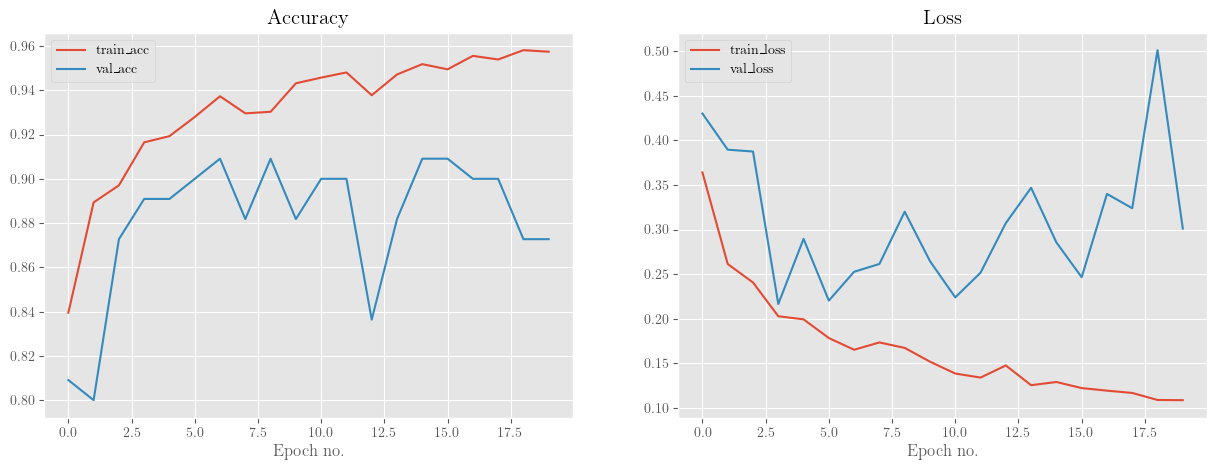

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 337ms/step
              precision    recall  f1-score   support

    diseased       0.84      0.93      0.88        55
     healthy       0.92      0.82      0.87        55

    accuracy                           0.87       110
   macro avg       0.88      0.87      0.87       110
weighted avg       0.88      0.87      0.87       110

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 342ms/step - accuracy: 0.8201 - loss: 0.4010
Test loss: 0.3011307120323181
Test accuracy: 0.8727272748947144


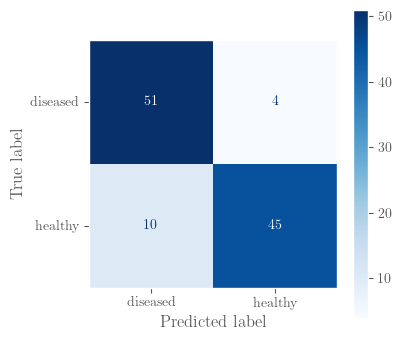

In [180]:
print("[INFO] evaluating network...")
plot_model_outcomes(HV2, epochs)

get_model_evaluation(MobileNetV2_model, test_generator, valid_generator, batch_size)

Right away, with only 10 epochs, this model is doing much better than ours. Still, its performance on the validation set has plateaued and is starting to decline, indicating some overfitting. With such a powerful model and such a small dataset, it's a delicate balance. 

8
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


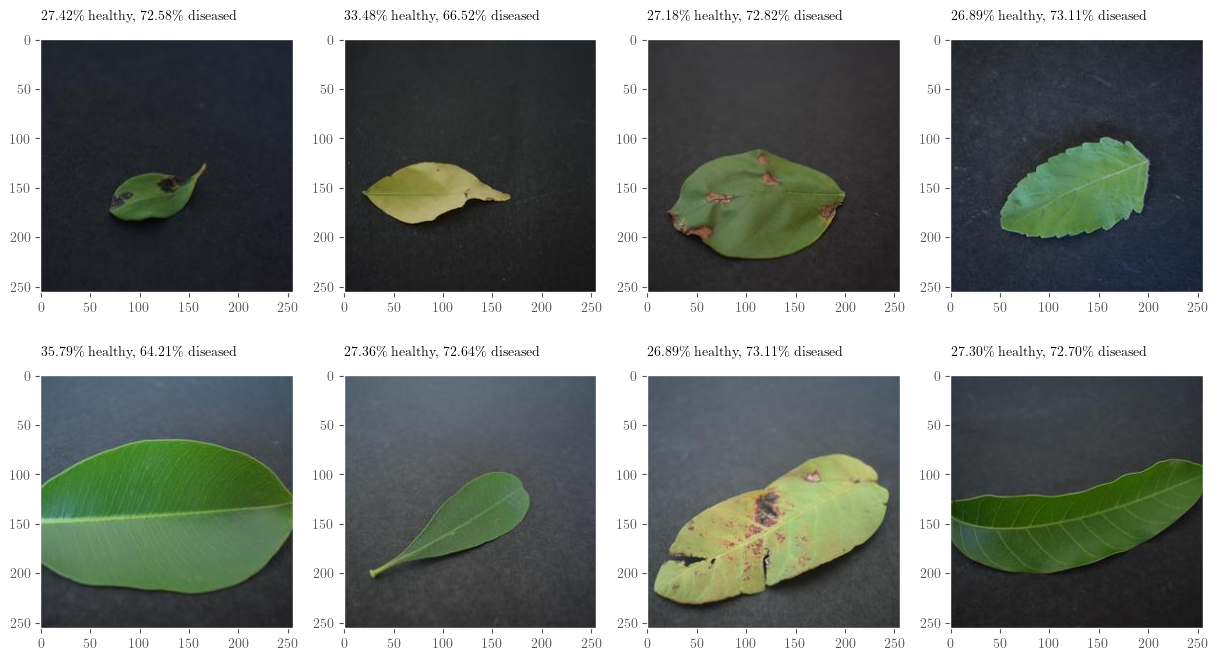

In [181]:
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
ax_list = list(axes.flat)[::-1]
num_subplots = len(ax_list)
print(num_subplots)
for i in range(num_subplots):
    ax = ax_list.pop()
    plot_predict(MobileNetV2_model, files_to_predict[i], ax)